# Neural Machine Translation

Build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25") ... using an attention model. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -R gdrive/My\ Drive/Colab\ Notebooks/DeepLearning.ai/W3MachineTranslation/* .

In [0]:
# !pip install faker
# !pip install babel

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1 - Translating human readable dates into machine readable dates

### 1.1 - Dataset

10000 human readable dates and their equivalent, standardized, machine readable dates.

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 19303.42it/s]


In [3]:
dataset[10:20]

[('friday june 16 1978', '1978-06-16'),
 ('friday june 18 1999', '1999-06-18'),
 ('8 oct 1987', '1987-10-08'),
 ('tuesday april 1 2008', '2008-04-01'),
 ('6 september 2012', '2012-09-06'),
 ('12 november 1981', '1981-11-12'),
 ('friday august 19 2011', '2011-08-19'),
 ('25 08 07', '2007-08-25'),
 ('18 september 1982', '1982-09-18'),
 ('friday february 25 1994', '1994-02-25')]

- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Tx is the number of max characters in human readable dates. If longer, will be truncated.
Ty is the number of max characters in machine readable dates

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


Visualize Pre-processing

In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2 - Neural machine translation with attention




 [RepeatVector()](https://keras.io/layers/core/#repeatvector), [Concatenate()](https://keras.io/layers/merge/#concatenate), [Dense()](https://keras.io/layers/core/#dense), [Activation()](https://keras.io/layers/core/#activation), [Dot()](https://keras.io/layers/merge/#dot).

In [0]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [0]:
# one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    
    return context

Implement `model()`. Global Layers defined above share weights

In [0]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [0]:
# model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
       
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model((X,s0,c0), outputs)
    
    
    
    return model

Create the model.

In [0]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

A summary of the model...

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

Compile the model in Keras. 

Loss : `categorical_crossentropy` loss

Optimizer : a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)

Metrics : accuracy

In [0]:

opt = model.compile(optimizer=Adam(lr = 0.005, beta_1=0.9, beta_2=0.999, decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
opt


Define all the inputs and outputs to fit the model:
- X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- `s0` and `c0` to initialize the `post_activation_LSTM_cell` with 0s.
- Given the `model()`, "outputs" need to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [0]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [14]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 24s 2ms/step - loss: 16.9152 - dense_3_loss: 2.5260 - dense_3_acc: 0.4199 - dense_3_acc_1: 0.7001 - dense_3_acc_2: 0.3269 - dense_3_acc_3: 0.0806 - dense_3_acc_4: 0.9066 - dense_3_acc_5: 0.3100 - dense_3_acc_6: 0.0493 - dense_3_acc_7: 0.9176 - dense_3_acc_8: 0.2659 - dense_3_acc_9: 0.1104


`dense_2_acc_8: 0.89` means that the 7th character of the output is predicted correctly 89% of the time in the current batch of data.

In [0]:
model.load_weights('models/model.h5')

Test some examples...

In [0]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

## 3 - Visualizing Attention




In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. 

The function `attention_map()` pulls out the attention values from that layer and plots them.

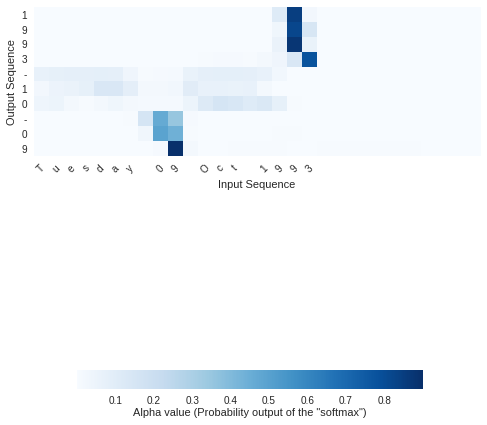

In [18]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)